<div align="left" style="float: left;">
    
###### CC2006 - Inteligência Artificial


</div>

<div align="right" style="float: right;">
    
###### _Robert Gleison dos Reis Pereira (up202200496)_  
###### _Sophia Cheto de Queiroz Fonseca (up202200336)_    
###### _Guilherme Magalhães (up202205505)_  

</div>

####
# Connect4 

Criação de um jogo Connect Four usando algoritmos de Inteligência Artificial: A*, Alpha-Beta Pruning e Monte Carlo Tree Search

_O código completo (com execução pelo Pygame e comentários sobre cada parte do código) está armazenado no seguinte repositório do GitHub: 
https://github.com/RobertGleison/connect4.git_





---


## Introdução

#### Sobre o jogo:
Connect 4, também conhecido como Quatro em Linha, é um jogo de estratégia para dois jogadores. O objetivo é ser o primeiro a alinhar quatro peças da mesma cor consecutivamente, seja na vertical, horizontal ou diagonal, em um tabuleiro vertical com sete colunas e seis linhas. Os jogadores alternam colocando suas peças em uma coluna vazia, tentando bloquear o adversário enquanto procuram formar sua própria sequência de quatro peças.

#### O nosso projeto:

O jogo foi desenvolvido em Python, usando a biblioteca numpy como auxílio para as matrizes que representam o tabuleiro. Para a interface gráfica, utilizamos o Pygame para criar uma melhor interação com o usuário.  
Há dois modos de jogo: "Player vs Player", para dois jogadores, e "Single Player", onde o jogador joga contra o computador. No segundo modo, foram implementados os seguintes algoritmos, com suas respectivas identificações na interface do Pygame:
* A* _(fácil)_
* A* Adversarial _(médio)_
* Alpha-Beta Pruning _(difícil)_
* Monte Carlo Tree Search _(desafio)_  


#### Considerações:
Para a apresentação do código neste notebook, optamos por retirar a integração com o Pygame, gerando um código mais limpo e mais fácil de compreender pela leitura. Assim, aqui temos apenas o programa lógico e algorítimico do jogo. O código completo está disponível no GitHub.




---

# Estrutura do projeto:


<div align="left">
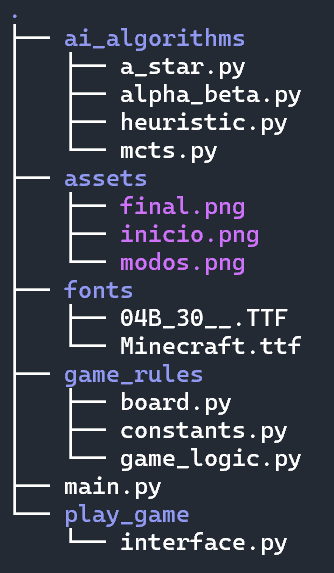
</div>


####  Armazenamento nos Diretórios
* **ai_algorithms:** códigos dos algoritmos de decisão propostos  
* **assets:** arquivos de imagem para o README.md  
* **fonts:** fontes usadas na interface gráfica  
* **game_rules:** códigos base do jogo, tais como validações, lógicas de jogo, constantes e tabuleiro  
* **heuristics:** códigos das heurísticas usadas pelos algoritmos de decisão  
* **play_game:** códigos da interface gráfica e loop do jogo

---

# **Estrutura do Jogo** (game_rules)

Antes de desenvolver os algoritmos criados, precisamos importar uma série de validações e regras lógicas que fazem o jogo funcionar.

In [3]:
import sys
import numpy as np
import math
import os
import time
import random
import itertools
from math import sqrt, log
from dataclasses import dataclass, field
from IPython.display import clear_output

### constants.py
As variáveis globais usadas durante toda a execuçãodo jogo são armazenadas em um arquivo constants.py.

In [4]:
HUMAN_PIECE = 1
AI_PIECE = 2

# Constants for the data matrix
ROWS = 6
COLUMNS = 7

### board.py
O estado do jogo é armazenado na classe abaixo, baiscamente é uma matriz 6x7 que se completa com valores 1 e 2, que são as peças dos jogadores

In [5]:
@dataclass
class Board:
    rows: int = ROWS
    columns: int = COLUMNS
    board: np.ndarray = field(default_factory=lambda: np.zeros((ROWS, COLUMNS)))
            
    def get_board(self) -> np.ndarray:
        return self.board

    def print_board(self) -> None:
        print(np.flip(self.board, 0), "\n")

### game_logic.py

In [6]:
def human_move(bd: Board, board: np.ndarray, turn: int, game_mode: int, interface: any) -> bool:
	"""Set the column of human move"""
	print("\nEscolha uma coluna de 1 a 7: ", end='')
	col = int(input()) -1
	while not 0 <= col < 7:
		print("Número de coluna inválida. Escolha novamente: ", end='')
		col = int(input()) -1
	if not is_valid(board, col): return False 
	make_move(bd, board, turn, col, game_mode, interface)
	return True

def make_move(bd: Board, board: np.ndarray, turn: int, move: int, game_mode: int, interface: any) -> bool:
    """Make the move and see if the move is a winning one"""
    row = get_next_open_row(board, move)
    drop_piece(board, row, move, turn)   
    clear_output(wait=True)
    interface.print_game_modes(game_mode)
    display(bd.print_board())
    return winning_move(board, turn) or is_game_tied(board)

def ai_move(bd: Board, game_mode: int, board: np.ndarray, turn: int, interface: any) -> int:
	"""Set the column of the AI move"""
	ai_column = get_ai_column(board, game_mode)
	game_over = make_move(bd, board, turn, ai_column, game_mode, interface)
	return game_over

def get_ai_column(board: Board, game_mode: int) -> int:
	"""Select the chose ai algorithm to make a move"""
	chosen_column = 0
	if game_mode == 2:
		chosen_column = a_star(board, AI_PIECE, HUMAN_PIECE)
	elif game_mode == 3:
		chosen_column = a_star_adversarial(board, AI_PIECE, HUMAN_PIECE)
	elif game_mode == 4:
		chosen_column = alpha_beta(board)
	elif game_mode == 5:
		chosen_column = mcts(board)
	return chosen_column

def simulate_move(board: np.ndarray, piece: int, col: int) -> None | np.ndarray:
	"""Simulate a move in a copy of the board"""
	board_copy = board.copy()
	row = get_next_open_row(board_copy, col)
	if row == None: return None
	drop_piece(board_copy, row, col, piece)
	return board_copy

def get_next_open_row(board: np.ndarray, col: int) -> int:
	"""Given a column, return the first row avaiable to set a piece"""
	for row in range(ROWS):
		if board[row][col] == 0:
			return row
	return -1

def available_moves(board: np.ndarray) -> list | int:
    """Return list of available columns to play"""
    available_moves = []
    for i in range(COLUMNS):
        if board[5][i] == 0:
            available_moves.append(i)
    return available_moves if len(available_moves) > 0 else -1


def drop_piece(board: np.ndarray, row: int, col: int, piece: int) -> None:
	"""Insert a piece into board on correct location"""
	board[row][col] = piece

def is_game_tied(board: np.ndarray) -> bool:
	"""Assert if the game is tied"""
	if winning_move(board, AI_PIECE) or winning_move(board, HUMAN_PIECE): return False
	for i in range(len(board)):
		for j in range(len(board[0])):
			if board[i][j]==0: return False
	return True

def is_valid(board: np.ndarray, col: int) -> bool:
	"""Analize if chosen column is valid"""
	if not 0 <= col < COLUMNS: return False
	row = get_next_open_row(board, col)
	return 0 <= row <= 5

def winning_move(board: np.ndarray, piece: int) -> bool:
	"""Return if the selected move will win the game"""
	def check_horizontal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on horizontal lines"""
		for col in range(COLUMNS-3):
			for row in range(ROWS):
				if board[row][col] == piece and board[row][col+1] == piece and board[row][col+2] == piece and board[row][col+3] == piece:
					return True	

	def check_vertical(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on vertical lines"""
		for col in range(COLUMNS):
			for row in range(ROWS-3):
				if board[row][col] == piece and board[row+1][col] == piece and board[row+2][col] == piece and board[row+3][col] == piece:
					return True		

	def check_ascending_diagonal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on ascending diagonal lines"""
		for col in range(COLUMNS-3):
			for row in range(ROWS-3):
				if board[row][col] == piece and board[row+1][col+1] == piece and board[row+2][col+2] == piece and board[row+3][col+3] == piece:
					return True	

	def check_descending_diagonal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on descending diagonal lines"""
		for col in range(COLUMNS-3):
			for row in range(3, ROWS):
				if board[row][col] == piece and board[row-1][col+1] == piece and board[row-2][col+2] == piece and board[row-3][col+3] == piece:
					return True
				
	return check_vertical(board, piece) or check_horizontal(board, piece) or check_ascending_diagonal(board, piece) or check_descending_diagonal(board, piece)

---


# **Algoritmos** (ai_algorithms)


## **Heurística** (heuristics.py)

Para 3 dos 4 algoritmos (A*, A* Adversarial, Alpha-Beta), utilizamos a mesma heurística, que foi baseada num cálculo de pontos para cada estado do tabuleiro. Primeiramente, vamos entender como ela funciona.  

Dado um estado de jogo(matriz 6x7 com distribuição de peças), queremos avaliar a pontuação desse estado específico.  
A cada 4 espaços do tabuleiro são contadas as peças de cada jogador e atribui-se uma quantidade de pontos a esse segmento. No final do tabuleiro, somam-se as pontuações de cada segmento para calcular a pontução geral daquele estado.  



#### Funções 

Para isso, foram criadas duas funções auxiliares para avaliar o score the determinado estado (posições das peças):  

A função **calculate_board_score()** segmenta a matriz em segmentos de 4 espaços (verticalmente, horizontalmente e diagonalmente).
Logo após, o segmento é passado como argumento para a função **weights()**, que calcula um valor de pontos associado a esse bloco de acordo com o número de peças de cada jogador existem no segmento.  
Para cada segmento, utilizamos a seguinte heurística, sendo "Player 1" = jogador e "Player 2" = IA:  

- Existem peças do Player 1 e do Player 2 = **0 pontos**
- 1 peça do Player 2 = **1 ponto**
- 2 peças do Player 2 = **10 pontos**
- 3 peças do Player 2 = **50 pontos**
- 4 peças do Player 2 = **1000 pontos**
- 1 peça do Player 1 = **-1 ponto**
- 2 peças do Player 1 = **-10 pontos**
- 3 peças do Player 1 = **-50 pontos**
- 4 peças do Player 1 = **-2000 pontos**

In [7]:
def calculate_board_score(board: np.ndarray, piece: int, opponent_piece: int) -> int:
    score = 0

    # Check horizontal
    for col in range(COLUMNS - 3):
        for r in range(ROWS):
            segment = [board[r][col + i] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    # Check vertical
    for col in range(COLUMNS):
        for r in range(ROWS - 3):
            segment = [board[r + i][col] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    # Check ascending diagonal
    for col in range(COLUMNS - 3):
        for r in range(ROWS - 3):
            segment = [board[r + i][col + i] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    # Check descending diagonal
    for col in range(COLUMNS - 3):
        for r in range(3, ROWS):
            segment = [board[r - i][col + i] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    return score

In [8]:
def weights(segment: list, piece: int, opponent_piece: int) -> int:
    if piece in segment and opponent_piece in segment: return 0
    if segment.count(piece) == 1: return 1
    if segment.count(piece) == 2: return 10
    if segment.count(piece) == 3: return 50
    if segment.count(piece) == 4: return 1000
    if segment.count(opponent_piece) == 1: return -1
    if segment.count(opponent_piece) == 2: return -10
    if segment.count(opponent_piece) == 3: return -50
    if segment.count(opponent_piece) == 4: return -2000
    return 0

Essa pontuação tenta simular um cálculo de probabilidade de vitória com uma certa jogada. Quanto mais perto de completar uma sequência de 4 peças, maior a pontuação. De forma análoga, quanto mais perto estiver o jogador oponente de uma sequência de 4 peças, mais negativo será a pontuação (pois queremos evitar a vitória do oponente). Quando há peças dos dois jogadores num segmento, esse espaço não pode mais representar uma possibilidade de viória para nenhum dos dois jogadores, logo, recebe uma pontuação nula.  

As pontuações são simétricas, exceto quando se tem as 4 posições preenchidas com peças do mesmo jogador, onde a pontuação de 4 peças inimigas equivale ao dobro (negativo) da pontuação de 4 peças aliadas. Isso acontece para que evitar a vitória do inimigo seja sempre a prioridade, em vez de preferir acumular pontos.  

Nota-se também que a pontuação é calculada com apenas uma procura na tabela. Inicialmente, havíamos tentando fazer uma varredura pela matriz em busca de cada uma das pontuações especificamente, o que gerava uma repetição desnecessária da procura. O modelo atual de implementação é um método mais eficiente de percorrer a matriz.

### Exemplo de utilização:

Dado o estado do tabuleiro abaixo criado, realizamos uma chamada à função calculate_board_state(), para avaliar a pontuação desse estado específico.

In [27]:
estado1 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 2, 0, 0, 0, 0, 0],
          [0, 2, 2, 2, 0, 0, 0],
          [0, 1, 1, 2, 1, 0, 0],
          [1, 1, 2, 1, 1, 1, 2]]


estado2 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 2, 0, 0, 0, 0, 0],
          [0, 2, 2, 2, 1, 0, 0],
          [2, 1, 1, 2, 1, 0, 2],
          [1, 1, 2, 1, 1, 1, 2]]


In [28]:
print("Score do estado 1: ", calculate_board_score(estado1, AI_PIECE, HUMAN_PIECE))
print("Score do estado 2: ", calculate_board_score(estado2, AI_PIECE, HUMAN_PIECE))

Score do estado 1:  181
Score do estado 2:  78


---

Agora que já podemos calcular as pontuções atríbuidas para cada estado, é necessário desenvolver algoritmos para escolher a melhor jogada.  

## **A\*** (a_star.py)

O algoritmo A* é um método de decisão que escolhe a melhor coluna para uma jogada, baseando-se apenas na melhor pontuação das 7 possibilidades existentes imediatamente após o estado atual.  

Para a sua implementação, criamos uma cópia do estado atual, realizamos uma jogada em cada coluna disponível e comparamos as pontuações obtidas com cada uma delas. A jogada que retornar a melhor pontuação será a escolhida. Simples assim.

In [9]:
def a_star(board: np.ndarray, ai_piece: int, opponent_piece: int) -> int:
    """Return the best column chose by A* algorithm"""
    # start_time = time.time()
    best_score = float('-inf')
    best_move = -1
    for col in available_moves(board):
        simulated_board = simulate_move(board, ai_piece, col)
        cur_score = calculate_board_score(simulated_board, ai_piece, opponent_piece)
        if cur_score > best_score:
            best_move = col
            best_score = cur_score
    # end_time = time.time()
    # print(f"Tempo de resposta = {end_time-start_time}")
    return best_move


### Exemplo de utilização:

Abaixo, utilizaremos o mesmo estado mostrado antes. O próximo jogador a jogar é o Player 2, que será controlado pelo A*. Logo, a coluna 5 é a melhor jogada, pois ele completaria uma linha horizontal com 4 peças, ganhando o jogo. Veremos como o algoritmo calcula a melhor jogada.

In [10]:
estado3 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                              [0, 1, 1, 2, 1, 1, 0],
                                                              [0, 2, 2, 2, 0, 0, 0],
                                                              [0, 2, 0, 0, 0, 0, 0],
                                                              [0, 0, 0, 0, 0, 0, 0],
                                                              [0, 0, 0, 0, 0, 0, 0]]))


print("Melhor jogada no estado 3 para o player 2: coluna", a_star(estado3, AI_PIECE, HUMAN_PIECE)+1)

Melhor jogada no estado 3 para o player 2: coluna 5


Como vemos, o A* teve sucesso ao calcular a melhor jogada para a sua vitória. Porém, por não ser um algoritmo para jogos adversariais, ele não consegue evitar a vitória do oponente.  

Embora tenhamos atribuído uma maior pontuação para sequências de 4 peças inimigas em relação á 4 peças aliadas, isso não é útil para o A*, uma vez que ele não consegue fazer previsões de jogadas do oponente. Esse algoritmo joga apenas procurando a sua própria vitória, independente do inimigo. Assim, só prejudica o jogo do outro jogador quando é para se beneficiar, mas não com o objetivo de evitar sua vitória inimiga.  
Para corrigir essa falha, adaptamos o A* para que funcione como um jogo adversarial

---

## **A\* Adversarial** (a_star.py)

Nessa adaptação, o A* avalia qual seria a melhor opção de coluna por meio da simulação das duas jogadas seguintes ao estado atual. Primeiro ele simula o score the cada jogada, e para cada simulação, ele também simula a melhor jogada inimiga em cima de sua própria jogada. Assim, em vez de simular apenas a jogada imediatamente seguinte (como faz o A* original), ele consegue jogar para evitar que o inimigo tenha boas jogadas
. 
Além disso, podemos fazer algo divertido para interagir com o jogador: mostrar uma dica de jogada optimal para o oponente, visto que ela já é calculada durante a previsão de jogada da IA.

Com isso, resolvemos o problema do A* anterior, pois agora conseguimos jogar para evitar a vitória do oponente, caso ela fosse ocorrer logo na sua jogada seguinte. No entanto, ainda não conseguimos prever o jogo além das duas jogadas seguintes. Para isso, temos o MCTS e o AlphBeta, que conseguem prever um maior número de jogadas seguintes de forma mais eficiente.  

In [11]:
def a_star_adversarial(board: np.ndarray, ai_piece: int, opponent_piece: int) -> int:
    """Return the best column chose by predictive A* algorithm"""
    start_time = time.time()
    move_score = float('-inf')
    best_move = -1
    best_opponent = 0;
    possible_moves = available_moves(board)
    if len(possible_moves) == 1: return possible_moves[0]
        
    for col in possible_moves:
        simulated_board = simulate_move(board, ai_piece, col)
        if winning_move(simulated_board, AI_PIECE): return col
            
        opponent_col = a_star(simulated_board, opponent_piece, ai_piece)  
        opponent_simulated_board = simulate_move(simulated_board, opponent_piece, opponent_col)
        cur_score = calculate_board_score(opponent_simulated_board, ai_piece, opponent_piece)
        if cur_score > move_score:
            best_opponent = opponent_col + 1
            best_move = col
            move_score = cur_score
    end_time = time.time()
    print(f"Tempo de resposta = {end_time-start_time}")
    print("Próximo passo sugerido para o oponente: coluna " + str(best_opponent+1))
    return best_move

### Exemplo de utilização:


In [12]:
estado4 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                               [0, 1, 1, 2, 1, 1, 0],
                                                               [0, 2, 2, 2, 0, 0, 0],
                                                               [0, 2, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0]]))

In [13]:
print("Jogada escolhida para o Player 2:", a_star_adversarial(estado4, AI_PIECE, HUMAN_PIECE)+1)

Jogada escolhida para o Player 2: 5


Nota-se que não há sugestão de jogada seguinte, pois, como uma das jogadas leva a IA diretamente à vitória, a função é interrompida ao meio para retornar a coluna vencedora.

---

## **Alpha-Beta Pruning** (alpha_beta.py)

O algoritmo Alpha-Beta percorre uma árvore completa, em que cada um de seus nós representa um estado do tabuleiro. A cada nível, o nó escolhido para retornar a pontuação é o da melhor jogada possível para o jogador atual.  
Ou seja, ao calcular a melhor jogada no nível em que o oponente joga, é escolhido o nó com a pontuação mais negativa (que mais beneficia o oponente). Já no nível em que a IA joga, é escolhido o nó com maior pontuação. Ao final, escolhe-se qual das 7 possíveis jogadas da IA gera uma melhor pontuação a longo prazo, no decorrer do jogo.  
A base dessa descrição é a mesma do algoritmo MiniMax, mas o AlphaBeta possui uma eficiência maior, uma vez que descarta galhos da árvore que já são perceptivelmente desnecessários. Assim, optamos por implementar apenas o Alpha-Beta, e não o MiniMax.

#### Funcionamento
Para que o algoritmo Alpha-Beta possa escolher a melhor jogada possível, ele também se utiliza da heurística. Para que o algoritmo funcione, precisamos definir um limite, caso contrário, ele testaria todas as opções possíveis, o que ultrapassa os recursos computacionais disponíveis. Para isso, optamos pr limitar o algorítmo pela profundidade (variável depht_limit).

Com o limite escolhido, o Alpha-Beta percorre estados filhos até que encontre um estado em que o jogo termine, ou até atingir o limite de profundidade, e depois retorna o resultado da pontuação deste nó, atualizando os valores de mínimo e máximo. A partir daí, os nós pais alternam entre pegar a pontuação máxima onde as peças aliadas estão jogando e a pontuação mínima onde as peças inimigas estão jogando, aplicando cortes dos ramos com as atualizações de valores máximos e mínimos (alpha e beta). 

O nó raíz é o estado atual do jogo, que pega o maior score possível entre os filhos do nível 1, para maximizar as chances de vitória do jogador atual, no nível 2, simulamos a jogada do oponente supondo que ele escolha uma jogada que vai minimizar nosso score, e assim alternamos até o último nó alcançavel.


In [14]:
def alpha_beta(board: np.ndarray) -> int:
    """Return the best column chose by alpha_beta algorithm"""
    start_time = time.time()
    children = get_children(board, AI_PIECE)
    depth_limit = 5
    best_move = -1
    best_score = float('-inf')
    for (child, col) in children:
        if winning_move(child, AI_PIECE): 
            best_move = col
            break
        score = calculate(child, 0, float('-inf'), float('+inf'), depth_limit, False)
        if score > best_score:
            best_score = score
            best_move = col
    end_time = time.time()
    print(f"Tempo de resposta = {end_time-start_time}")
    return best_move


def calculate(board: np.ndarray, depth: int, alpha: int, beta: int, depth_limit: int, maximizing: bool) -> int:
    """Return the accumulated score for this current move"""
    if depth == depth_limit or winning_move(board, 1) or winning_move(board, 2) or is_game_tied(board):
        return calculate_board_score(board, AI_PIECE, HUMAN_PIECE)
    
    if maximizing:
        maxEval = float('-inf')
        children = get_children(board, AI_PIECE)
        for (child, col) in children:
            eval = calculate(child, depth+1, alpha, beta, depth_limit, False)
            maxEval = max(maxEval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return maxEval
    
    else:
        minEval = float('+inf')
        children = get_children(board, HUMAN_PIECE)
        for (child, col) in children:
            eval = calculate(child, depth+1, alpha, beta, depth_limit, True)
            minEval = min(minEval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return minEval


def get_children(board: np.ndarray, piece: int):
    """Return children of the actual state board"""
    children = []
    if available_moves(board) == -1: return children 
    for col in available_moves(board):  
        copy_board = simulate_move(board, piece, col)   
        children.append((copy_board, col)) 
    return children

### Exemplo de utilização:

Nessa implementação, fizemos uma pequena modificação no algoritmo Alpha Beta original: fazemos uma checagem inicial de vitória (entre as opções diretas de jogadas da IA). Com isso, o comportamento do algoritmo se aproxima mais do comportamento de um humano: se uma jogada gerar uma vitória, não checa mais nenhuma possibilidade e já seleciona aquela como a melhor jogada.
Assim, em tabuleiros em que há uma vitória iminente da IA (como a seguir), o tempo de execução do algoritmo é muito menor.

In [15]:
estado5 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                               [0, 1, 1, 2, 1, 1, 0],
                                                               [0, 2, 2, 2, 0, 0, 0],
                                                               [0, 2, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0]]))

print("Melhor jogada board4 para o jogador 2:", alpha_beta(estado5)+1)

Tempo de resposta = 0.9023516178131104
Melhor jogada board4 para o jogador 2: 5


---

## **Monte Carlo Tree Search** (mcts.py)



***Classe Node**:* Representa um nó na árvore de busca do MCTS. Cada nó tem as seguintes informações:
1. O estado atual do tabuleiro do jogo
1. O nó pai, contendo informações como o estado anterior do tabuleiro
2. Os nós filhos, contendo informações como os possíveis movimentos para se jogar e criar um novo tabuleiro.
3. O número de visitas deste nó (vezes que já foi explorado)
4. O número de vitórias deste nó (quantidade de vezes que esse nó leva à vitória nas simulações)
5. O jogador atual do estado.
  
Funções:
1. *ucb()*: calcula a UCB (Upper Confidence Bound) para balancear a exploração e a exploração durante a seleção de movimentos
2. *add_children()*: adiciona possíveis movimentos (nós filhos) ao nó
3. *score()*: retorna o valor da pontuação de um nó,calculado a partir das suas visitas e vitórias.

In [16]:
@dataclass
class Node:
    def __init__(self, board, last_player, parent=None) -> None:
        self.board = board
        self.parent = parent
        self.children = []
        self.visits = 0
        self.wins = 0  
        self.current_player = 1 if last_player == 2 else 2

    def __str__(self) -> str:
        string = "Vitórias: " + str(self.wins) + '\n'
        string += "Total: " + str(self.visits) + '\n'
        string += "Pontuação: " + str(self.ucb()) + '\n'
        string += "Probabilidade de vitória: " + str(self.score()) + '\n'
        return string

    def add_children(self) -> None:
        """add each possible move to a list of possible children for the current node/state"""  
        if (len(self.children) != 0) or (available_moves(self.board) == -1): return   # se não existirem jogadas possíveis ou se os filhos já tiverem sido adicionados
        for col in available_moves(self.board):  # itera sobre todas as colunas possíveis a serem jogadas
            if self.current_player == HUMAN_PIECE:  
                copy_board = simulate_move(self.board, AI_PIECE, col)
            else: 
                copy_board = simulate_move(self.board, HUMAN_PIECE, col)    # cria uma cópia do tabuleiro atual e adiciona a nova jogada a ele
            self.children.append((Node(board=copy_board, last_player=self.current_player, parent=self), col))  # adiciona cada tabuleiro gerado a uma lista, junto com a identificação da coluna que o gerou

    def select_children(self):
        """randomly select a maximum of 4 children"""
        if (len(self.children) > 4):
            return random.sample(self.children, 4)
        return self.children
    
    def ucb(self) -> float:
        """calculate the Upper Confidence Bound of the node"""
        if self.visits == 0: return float('inf')
        exploitation = self.wins / self.visits
        exploration = sqrt(2) * sqrt(2 * log(self.parent.visits / self.visits, math.e)) if self.parent else 0
        return exploitation + exploration
    
    def score(self) -> float:
        """calculate the score of the node"""
        if self.visits == 0: return 0
        return self.wins / self.visits

***Classe MCTS**:* Controla a busca MCTS a partir de um nó raiz. A função search executa a busca dentro de um limite de tempo. Durante a busca, são realizadas quatro etapas principais: seleção, expansão, simulação (rollout) e backpropagate.
1. Início: A função *start()* expande todos os filhos do estado atual e faz 6 simulações em cada um deles antes de iniciar a lógica do mcts
2. Pesquisa: A função *search()* itera sobre os nós da árvore, dentro do limite de tempo estabelecido, percorrendo a partir da raiz:  
    \- seleciona o nó folha que possui o caminho até ele pelos maiores ucb's  
    \- se o nó ainda não estiver participado de uma simulação, faz rollout sobre ele  
    \- se já tiver alguma visita, expande e simula uma vez sobre cada um dos 4 filhos selecionados na expansão
2. Seleção: A função *select()* escolhe um nó folha da árvore para expandir/simular, iterando sobre ela baseado no UCB de cada nó.
4. Expansão: A função *expand()* adiciona novos nós filhos (possíveis movimentos) à árvore e retorna, no máximo, 4 filhos a serem simulados.
5. Simulação (Rollout): A função *rollout()* realiza simulações aleatórias do jogo até atingir um estado final de vitória ou empate.
6. Backpropagate: A função *back_propagation()* adiciona +1 às visitas de cada nó, e se o jogador atual de cada nó for o mesmo que ganhou na simulação em rollout, adiciona também +1 às vitórias.

*Função **mcts**:* Esta é a função de interface que inicializa a busca MCTS a partir do nó raiz e retorna a melhor coluna para o próximo movimento da AI.

In [17]:
@dataclass
class MCTS:
    def __init__(self, root: Node) -> None:
        self.root = root


    def start(self, max_time: int):           
        """simulate 6 times through each children of the root, before running mcts"""
        self.root.add_children()              
        for child in self.root.children:                                  # itera sobre todos os filhos da root
            if winning_move(child[0].board, AI_PIECE): return child[1]   # se alguma jogada já for vitoriosa, retorna
            for _ in range(6):                                            # simula 6 vezes sobre cada filho
                result = self.rollout(child[0])
                self.back_propagation(child[0], result)
        return self.search(max_time)                                      # inicia mcts
    

    def search(self, max_time: int) -> int:
        """iterate through the tree of possible plays"""
        start_time = time.time()
        while time.time() - start_time < max_time:  
            selected_node = self.select(self.root)    # seleciona o nó folha a ser estudado nessa iteração
            if selected_node.visits == 0:             # se o nó ainda não tiver sido visitado numa simulação:
                result = self.rollout(selected_node)              # simula
                self.back_propagation(selected_node, result)      # retropropagação da visita/vitória
            else:
                selected_children = self.expand(selected_node)     # se o nó já tiver sido simulado, expande e escolhe 4 filhos para simular
                for child in selected_children:
                    result = self.rollout(child[0])              # simula em cada um dos 4 filhos escolhidos
                    self.back_propagation(child[0], result)      # retropropagação
        return self.best_move()                                  # das possíveis jogadas, retorna a que gerou maior vitorias/visitas


    def select(self, node: Node) ->  Node:
        """select a leaf node to be expanded/simulated"""
        if node.children == []:           # caso base: o nó é uma folha
            return node                   # retorna ele mesmo
        else: 
            node = self.best_child(node)   # se o nó tiver filhos, escolhe o seu melhor filho
            return self.select(node)       # seleciona o melhor nó folha do filho escolhido

    
    def best_child(self, node: Node) -> Node:
        """select the best child to be expanded/simulated based on their ucb's"""
        best_child = None
        best_score = float('-inf')
        for (child, _) in node.children:
            ucb = child.ucb() 
            if ucb > best_score:
                best_child = child
                best_score = ucb
        return best_child


    def back_propagation(self, node: Node, result: int) -> None:
        """go through the tree to update the score of each node above the current one"""
        while node:                              # itera sobre todos os nós "pais" do último nó da simulação
            node.visits += 1                     # anota que mais uma simulação foi feita sobre esse nó
            if node.current_player == result:    # se o jogador desse nó tiver ganhado a partida simulada, anota mais uma vitória
                node.wins+=1           
            node = node.parent                   # passa ao pai do nó atual, para atualizar também o seu score
    

    def expand(self, node: Node) -> Node:
        """expand the node, by adding its children to the tree, and select 4 of them to be simulated"""
        node.add_children() 
        return node.select_children()
        
        
    def rollout(self, node: Node) -> int:
        """simulate a entire play until someone wins"""
        board = node.board.copy()   # cria uma cópia do tabuleiro do nó para ser alterado
        players = itertools.cycle([AI_PIECE, HUMAN_PIECE])  # cria uma iteração sobre os jogadores de cada nível
        current_player = next(players)
        while not (winning_move(board, AI_PIECE) or winning_move(board, HUMAN_PIECE)):   # continua a simulação até o jogo simulado acabar
            if is_game_tied(board): return 0
            current_player = next(players)
            values = available_moves(board)   # seleciona as colunas disponpiveis a receberem jogadas
            if values == -1:       # se não houver possibilidades de jogadas, retorna que não houve ganhador (empate)
                current_player = 0
                break
            col = random.choice(values)    # escolhe aleatoriamente uma das possibilidades de jogada
            board = simulate_move(board, current_player, col)  # simula a jogada escolhida
        return current_player       # retorna o jogador da jogada vencedora (ou seja, quem ganhou a simulação)
    

    def best_move(self) -> int:
        """select the best column to be played based on their scores"""
        max_score = float('-inf')
        scores = {}    # armazena os pares (col, score)
        columns = []   # armazena as colunas que têm o melhor score de vitórias
        for (child, col) in self.root.children:   # para cada possível jogada...
            score = child.score()      
            print(f"Coluna: {col}")
            print(child)
            if score > max_score:        
                max_score = score        # se esse for o novo melhor score, armazena como mehor
            scores[col] = score          # adiciona o par (col, score) ao dicionário
        for col, score in scores.items(): 
            if score == max_score:
                columns.append(col)      # seleciona todos os filhos que geram o melhor score
        return random.choice(columns)    # escolhe aleatoriamente um dos filhos com o melhor score


def mcts(board: np.ndarray) -> int:
    """Should return the best column option, chose by mcts"""
    root = Node(board=board, last_player=AI_PIECE)
    mcts = MCTS(root)
    column = mcts.start(3)
    return column

### Exemplo de utilização:

In [18]:
estado6 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                               [0, 1, 1, 2, 1, 1, 0],
                                                               [0, 2, 2, 2, 0, 0, 0],
                                                               [0, 2, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0]]))

print("Melhor jogada board4 para o jogador 2:", mcts(estado6)+1)

Melhor jogada board4 para o jogador 2: 5


---


# **Jogando** (play_game)

## interface.py
Aqui ficam armazenadas as funções relacionadas à interface do jogo e a execução do jogo dentro de um loop while que se repete até algum jogador ganhar ou o jogo der empate. Para criar a interface, utilizamos a biblioteca pygame. As funções de lógica do jogo estão bem integradas com o pygame, mas optamos por retirar toda a parte da interface para que fosse possível testar os algorítmos. No código original é mais complexo.

In [19]:
@dataclass
class Interface:
    rows: int = ROWS
    columns: int = COLUMNS

    def print_game_modes(self, value: int) -> None:
        game_modes = {1: 'Human x Human',
                      2: 'A*',
                      3: 'Predictive A*',
                      4: 'AlphaBeta',
                      5: 'MCTS'}
        print(f"Modo de jogo escolhido: {game_modes[value]}\n")

    def start_game(self, bd: Board) -> None:
        """Set up the conditions to the game, as choose game_mode and draw the pygame display"""
        game_mode = int(input("Selecione um modo de jogo:\n 1- A*\n 2- Predictive A*\n 3- AlphaBeta\n 4- MCTS\n")) +1
        # os.system('clear')
        clear_output(wait=True)
        self.print_game_modes(game_mode)
        bd.print_board()
        self.play_game(bd, game_mode)
        
    def play_game(self, bd: Board, game_mode: int) -> None:
        """Run the game"""
        board = bd.get_board()	
        game_over = False
        turns = itertools.cycle([1, 2])  
        turn = next(turns)

        while not game_over:
            if turn == 1 or (turn == 2 and game_mode == 1):  # get human move
                if not human_move(bd, board, turn, game_mode, self): continue  # make a move
                if winning_move(board, turn): 
                    game_over = True
                    break
                turn = next(turns)
            elif turn != 1 and game_mode != 1: 
                time.sleep(0.2)
                game_over = ai_move(bd, game_mode, board, turn, self)
                if game_over: break     
                turn = next(turns)
            # Evita que a ultima jogada no ultimo ponto possível retorne empate ao invès de vitória
            if is_game_tied(board) and game_over == False:
                print(f"Empate!")
                break   
        if not is_game_tied(board):
            print(f"Player {turn} venceu o jogo!")

## main.py
Para executar o jogo, basta digitar python3 main.py. Isso acionará o método main() e instanciará um objeto Board, um objeto Interface e chamara a função para rodar o jogo(Interface.start_game())





In [ ]:
def main() -> None:
    board = Board()
    interface = Interface()
    interface.start_game(board)
    
if __name__ == "__main__":
    main()

Modo de jogo escolhido: MCTS

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]] 


Escolha uma coluna de 1 a 7: 